In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

from sample_generators import CustomArgumentParser, TimeSeries
from sample_generation_tools import get_psd, get_waveforms_as_dataframe, apply_psd

## Read in the raw strain data

In [3]:
# -------------------------------------------------------------------------
# Read in the real strain data from the LIGO website
# -------------------------------------------------------------------------

event = 'GW150914'
data_path = '../data/'

# Names of the files containing the real strains, i.e. detector recordings
real_strain_file = {'H1': '{}_H1_STRAIN_4096.h5'.format(event),
                    'L1': '{}_L1_STRAIN_4096.h5'.format(event)}

# Read the HDF files into numpy arrays and store them in a dict
real_strains = dict()
for ifo in ['H1', 'L1']:

    # Make the full path for the strain file
    strain_path = os.path.join(data_path, 'strain', real_strain_file[ifo])

    # Read the HDF file into a numpy array
    with h5py.File(strain_path, 'r') as file:
        real_strains[ifo] = np.array(file['strain/Strain'])

## Calculate the Power Spectral Densities

In [4]:
# -------------------------------------------------------------------------
# Pre-calculate the Power Spectral Density from the real strain data
# -------------------------------------------------------------------------

psds = dict()
psds['H1'] = get_psd(real_strains['H1'])
psds['L1'] = get_psd(real_strains['L1'])

## Calculate the Standard Deviation of the Whitened Strain

In [5]:
white_strain = dict()
white_strain['H1'] = apply_psd(real_strains['H1'], psds['H1'])
white_strain['L1'] = apply_psd(real_strains['L1'], psds['L1'])

white_strain_std = {'H1':np.std(white_strain['H1']), 'L1':np.std(white_strain['L1'])}

## Load Pre-Computed Waveforms

In [6]:
# -------------------------------------------------------------------------
# Load the pre-calculated waveforms from an HDF file into a DataFrame
# -------------------------------------------------------------------------

waveforms_file = 'waveforms_3s_0700_1200_training.h5'
waveforms_path = os.path.join(data_path, 'waveforms', waveforms_file)
waveforms = get_waveforms_as_dataframe(waveforms_path)

## Create a sample timeseries

In [7]:
np.random.seed(423)
sample = TimeSeries(sample_length=12,
                    sampling_rate=4096,
                    max_n_injections=2,
                    loudness=1.0,
                    noise_type='real',
                    pad=3.0,
                    waveforms=waveforms,
                    psds=psds,
                    real_strains=real_strains,
                    white_strain_std=white_strain_std,
                    max_delta_t=0.01,
                    event_position=2048)

0.005856132734092202
[{'L1': 1.5748576438253739, 'H1': 2.0857707754403982}, {'L1': 2.4411311022124145, 'H1': 3.183925881277188}]


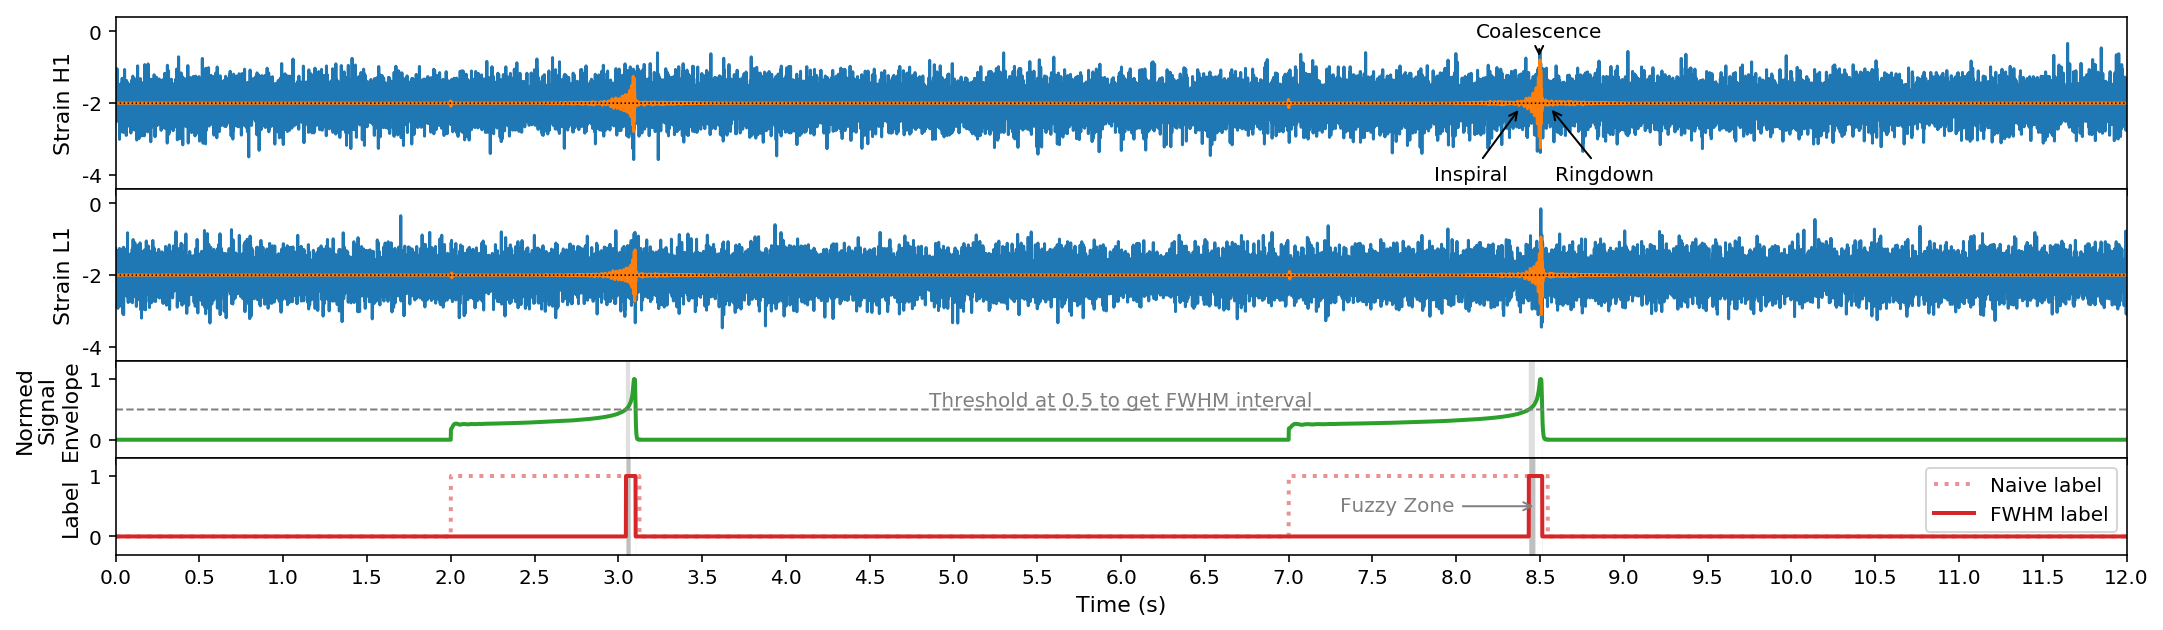

In [17]:
timeseries_H1 = sample.get_timeseries()[0, :, 0]
timeseries_L1 = sample.get_timeseries()[0, :, 1]
signals_H1 = sample.signals['H1']
signals_L1 = sample.signals['L1']
labels = sample.get_label()
chirpmasses = sample.get_chirpmass()
distances = sample.get_distance()
snrs = sample.get_snr()

print(sample.delta_t)
print(snrs)

grid = np.linspace(0, 12, 12*2048)

# For poster
# fig, axes = plt.subplots(nrows=4, ncols=1, sharex='col',
#                         gridspec_kw={'height_ratios': [5, 5, 2, 2]}, 
#                         figsize=(17.52, 6.1))

# For paper: 
fig, axes = plt.subplots(nrows=4, ncols=1, sharex='col',
                         gridspec_kw={'height_ratios': [4, 4, 2.25, 2.25]}, 
                         figsize=(4*4.50461, 4*1.235817933))

axes[0].plot(grid, timeseries_H1, color='C0')
axes[0].plot(grid, signals_H1, color='C1')
axes[0].plot(grid, [0 for _ in grid], color='Black', lw=0.75, ls=':')
axes[0].set_ylim(-6, 6)
axes[0].set_yticklabels(['', -4, -2, 0, 2, 4, ''])
axes[0].set_ylabel('Strain H1', fontsize=11)
axes[0].annotate("Coalescence", xy=(8.495, 3), xycoords='data', va='center', ha='center', xytext=(8.495, 5), textcoords='data', arrowprops=dict(arrowstyle='->'))
axes[0].annotate("Inspiral", xy=(8.385, -0.25), xycoords='data', va='center', ha='center', xytext=(8.085, -5), textcoords='data', arrowprops=dict(arrowstyle='->'))
axes[0].annotate("Ringdown", xy=(8.555, -0.25), xycoords='data', va='center', ha='center', xytext=(8.885, -5), textcoords='data', arrowprops=dict(arrowstyle='->'))

axes[1].plot(grid, timeseries_L1, color='C0')
axes[1].plot(grid, signals_L1, color='C1')
axes[1].set_ylim(-6, 6)
axes[1].plot(grid, [0 for _ in grid], color='Black', lw=0.75, ls=':')
axes[1].set_yticklabels(['', -4, -2, 0, 2, 4, ''])
axes[1].set_ylabel('Strain L1', fontsize=11)

# Calculate and plot the fuzzy-zones
THRESHOLD = 0.5
fuzzy_zones = -1 * np.ones(len(labels))
for j in range(len(labels)):
    if 0.5 < labels[j] < 0.6:
        fuzzy_zones[j] = 1
axes[2].fill_between(grid, -10, 10*fuzzy_zones, color='Gray', alpha=0.25, lw=0)

axes[2].plot(grid, labels, color='C2', lw=2)
axes[2].plot(grid, [THRESHOLD for _ in grid], color='Gray', lw=1, ls='--', )
axes[2].set_ylim(-0.3*np.max(labels), 1.3*np.max(labels))
axes[2].set_ylabel('Normed\nSignal\nEnvelope',  fontsize=11)
axes[2].text(6, 0.65, 'Threshold at 0.5 to get FWHM interval', ha='center', va='center', color='Gray')

axes[3].plot(grid, [1 if _ > 0 else 0 for _ in labels], color='C3', lw=2, ls=':', alpha=0.5, label='Naive label')
axes[3].plot(grid, [1 if _ > THRESHOLD else 0 for _ in labels], color='C3', lw=2, label='FWHM label')
axes[3].fill_between(grid, -2, 2*fuzzy_zones, color='Gray', alpha=0.5, lw=0)
axes[3].set_ylim(-0.3, 1.3)
axes[3].annotate("Fuzzy Zone", xy=(8.485, 0.5), xycoords='data', va='center', ha='center', xytext=(7.65, 0.5), textcoords='data', color='Gray', arrowprops=dict(arrowstyle='->', color='Gray'))

axes[3].set_ylabel('Label', fontsize=11)
axes[3].legend(loc='upper right')

fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.xlim(0, 12)
plt.xticks(np.linspace(0, 12, 25))
plt.xlabel('Time (s)', fontsize=11)
plt.savefig('training_sample.png', dpi=600, bbox_inches='tight')
plt.show()